In [159]:
import pandas as pd
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.regression.linear_model as sm
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.cross_validation import cross_val_score
from sklearn import feature_selection as f_select
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import r2_score
from statsmodels.regression.linear_model import RegressionResults
from scipy.stats.mstats import zscore
%matplotlib inline

In [160]:
# Load movie data
with open('result10.json') as f:
    data = json.load(f)

with open('studios.txt') as f:
    studios = []
    for s in f:
        studios.append(s.strip())
        

In [161]:
# Load inflation data
inf_index = pd.read_csv('inflation.csv', header=None)
inf_index.columns = ['year', 'inflation']
inf_index.year = inf_index.year.str.replace('[^\d]*', '').astype(int)
inf_index.inflation = inf_index.inflation.str\
                                            .replace('[^\w]*', '')\
                                            .astype(float)\
                                            .apply(lambda x: x/10000)

In [162]:
# Load dataframe
df = pd.DataFrame(data)
df.drop(['download_latency', 'download_slot','download_timeout', 'depth'], axis=1, inplace=True)
df.columns.tolist()

['budget',
 'country',
 'director',
 'genre',
 'language',
 'lifetime',
 'mojo_url',
 'mpaa',
 'opening',
 'rating',
 'rating_count',
 'release',
 'runtime',
 'studio',
 'theaters',
 'title',
 'url',
 'worldwide',
 'year']

In [163]:
# Replace None, nan, or n/a strings with np.nan
df = df.applymap(lambda x: np.nan if ((str(x).lower() == 'nan') or (str(x) == 'n/a') or (str(x) == 'None')) else x)

In [164]:
df = df.dropna(how='any')
df.shape

(2370, 19)

# Time to format and clean the data

In [165]:
def adjust_inflation(start_year, year):
    ci = 1
    for i in range(start_year, year + 1):
        ci *= (inf_index.loc[inf_index.year==i, 'inflation'].values + 1)
    return ci

In [166]:
def mpaa_num(s):
    code = {
        'G':5,
        'PG':4,
        'PG-13':3,
        'R':2,
        'NC-17':1
    }
    return code[s]

In [167]:
# Type conversions
df.rating = df.rating.astype(float)
df.runtime = df.runtime.astype(float)
df.year = df.year.astype(int)


df.opening = df.opening.str.replace(r'[^\d]', '').astype(float)
df.theaters = df.theaters.str.replace(r'[^\d]', '').astype(float)
df.lifetime = df.lifetime.str.replace(r'[^\d]', '').astype(float)
df.worldwide = df.worldwide.str.replace(r'[^\d]', '').astype(float)


# Datetime
df.release = pd.to_datetime(df.release, format='%Y-%m-%d')
df['month_cat'] = df.release.dt.strftime('%B')

# Currency Convert
df.budget = df.budget.str.replace(r'[^\d]', '').astype(float)

In [168]:
# Processed Columns

# Inflation Adjusted
start_year = 2000
l = ['opening', 'lifetime', 'worldwide', 'budget']
for e in l:
    df[str(e + '_adjusted')] = df.apply(lambda x: (x[e] * adjust_inflation(start_year, x['year'])), axis=1)[e]

# Log the money values
df['log_opening'] = np.log(df.opening)
df['log_lifetime'] = np.log(df.lifetime)
df['log_worldwide'] = np.log(df.worldwide)
df['log_budget'] = np.log(df.budget)

# Log inflation adjusted money values
df['log_opening_adjusted'] = np.log(df.opening_adjusted)
df['log_lifetime_adjusted'] = np.log(df.lifetime_adjusted)
df['log_worldwide_adjusted'] = np.log(df.worldwide)
df['log_budget_adjusted'] = np.log(df.budget_adjusted)

# Fix odd MPAA value
df.loc[df.mpaa =='PG-', 'mpaa'] = 'PG-13'
df.mpaa.value_counts()

# Make a ordinal MPAA column
df['mpaa_ord'] = df.mpaa.apply(mpaa_num)


In [169]:
def find_sig_cols(X, y, alpha=0.05):
    sig_cols = []
    for c in X.columns:
        pvalue = f_select.f_regression(X[[c]], y)[1][0]
        if pvalue <= alpha:
            sig_cols.append(c)

    return sig_cols

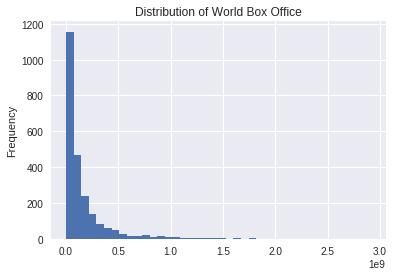

In [170]:
ax = df.worldwide_adjusted.plot(kind='hist', bins=40)
ax.set_title('Distribution of World Box Office')

Let's take a look at what columns may be relavent to predictin the domestic box office gross. If we begin to try to predict

In [171]:
# Release theaters divides opening
'''df_big = df[df.theaters > 50] #.plot(kind='hist', bins=40)
df_small = df[df.theaters < 50]
df_big.shape'''

"df_big = df[df.theaters > 50] #.plot(kind='hist', bins=40)\ndf_small = df[df.theaters < 50]\ndf_big.shape"

In [172]:
#df_small.log_opening.plot(kind='hist', bins=40)

In [173]:
df = df[df.theaters > 100]
df.columns

Index(['budget', 'country', 'director', 'genre', 'language', 'lifetime',
       'mojo_url', 'mpaa', 'opening', 'rating', 'rating_count', 'release',
       'runtime', 'studio', 'theaters', 'title', 'url', 'worldwide', 'year',
       'month_cat', 'opening_adjusted', 'lifetime_adjusted',
       'worldwide_adjusted', 'budget_adjusted', 'log_opening', 'log_lifetime',
       'log_worldwide', 'log_budget', 'log_opening_adjusted',
       'log_lifetime_adjusted', 'log_worldwide_adjusted',
       'log_budget_adjusted', 'mpaa_ord'],
      dtype='object')

In [174]:
df_work = df[['log_budget_adjusted', 'runtime', 'theaters', 'year']].apply(zscore, axis=0)
df_work['intercept'] = 1
model = sm.OLS(df.log_worldwide_adjusted, df_work)
fit = model.fit()
fit.summary()
df_work

,log_budget_adjusted,runtime,theaters,year,intercept
2,-1.007875,-0.624997,0.273710,1.717153,1
6,0.795722,0.463441,1.083055,1.717153,1
8,-0.063089,0.578013,0.773970,1.717153,1
9,1.893028,1.609164,1.884386,1.717153,1
11,1.178325,-0.109421,1.166622,1.717153,1
12,1.977145,2.353885,1.566143,1.717153,1
13,1.755344,1.036302,1.146017,1.717153,1
14,0.810558,-0.395852,1.540959,1.717153,1
15,2.037136,1.208161,1.803108,1.717153,1
18,1.662945,1.208161,1.727554,1.717153,1


In [175]:
pp = sns.pairplot(data=df2,
                  y_vars=['log_worldwide_adjusted'],
                  x_vars=['year','runtime'], kind='reg', size=8, aspect=1.5)

NameError: name 'df2' is not defined

In [ ]:
pp = sns.pairplot(data=df2,
                  y_vars=['log_worldwide_adjusted'],
                  x_vars=['log_budget'], kind='reg', size=8, aspect=1.5)

In [ ]:
pp = sns.pairplot(data=df,
                  y_vars=['worldwide'],
                  x_vars=['lifetime', 'runtime'], kind='reg', size=10, aspect=1.5)

In [ ]:
pp = sns.pairplot(data=df,
                  y_vars=['worldwide'],
                  x_vars=['mpaa_ord', 'rating'], kind='reg', size=10, aspect=1.5)

In [ ]:
sns.residplot(x='runtime', y='lifetime', data=df)

In [ ]:
sns.residplot(x='log_lifetime_adjusted', y='log_worldwide_adjusted', data=df)

In [ ]:

adj_feat = {
    'opening':0,
    'log_opening':0,
    'opening_adjusted':0,
    'log_opening_adjusted':0,
    'lifetime':0,
    'log_lifetime':0,
    'lifetime_adjusted':0,
    'log_lifetime_adjusted':0,
    'worldwide':0,
    'worldwide_adjusted':0,
    'log_worldwide':0,
    'log_worldwide_adjusted':0,
    'budget':0,
    'budget_adjusted':0,
    'log_budget':0,
    'log_budget_adjusted':1,
    'rating':0,
}

predict = 'log_worldwide_adjusted'
df_y = df_clean[predict]

non_model = ['genre', 'director', 
               'url', 'language', 
               'country', 'mojo_url',
              'rating_count', 
               'studio', 'release',
             'mpaa_ord', 'title'
            ]
for key,val in adj_feat.items():
    if not val:
        non_model.append(key)
df_mod = df_clean.drop(non_model,axis=1)
#df_mod.set_index(df_mod.title, inplace=True)
df_mod.columns.tolist()

In [ ]:
df_norm = pd.concat([df_mod[['log_budget_adjusted', 'runtime', 'theaters', 'year']].apply(zscore, axis=0), df_mod], axis=1)
model = sm.OLS(df_y, df_norm)
fit = model.fit()
fit.summary()

In [ ]:
sig_columns

In [ ]:
df.director.unique().size

In [143]:
# Corr Plots of important ones

In [144]:
# Manually fit select columns

In [145]:
# Use statsmodels to find summary

# Use cross-validation to check for overfitting


In [146]:
# Plug into Sklearn and build a pipeline

In [147]:
# Report Score

In [148]:
# Pull in other variables

In [149]:
# Create dummy columns

In [195]:
# Make top director column
top_5percent_directors = set(df.sort_values(by='lifetime', ascending=False).director.unique()[:int(df.director.unique().size * 0.05)])#.tolist()
df['top_director'] = df.director.apply(lambda x: 1 if (x in top_5percent_directors) else 0)

In [196]:
# Genre
genre_pre = df.set_index('title').genre.str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre')
dummy_genre = pd.get_dummies(genre_pre, prefix='g', columns=['genre']).groupby(level=0).sum().reset_index()
col = dummy_genre.columns.str.replace(' ', '')
dummy_genre.columns = col

In [73]:
# Language
#df.language = df.language.str.replace(' ', '_')
#language_pre = df.set_index('title').language.str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('language')
#dummy_language = pd.get_dummies(language_pre, prefix='l', columns=['language']).groupby(level=0).sum().reset_index()

In [197]:
# Month Dummy
df = pd.get_dummies(df, prefix='m', columns=['month_cat'])

In [198]:
# MPAA
df = pd.get_dummies(df, prefix='m', columns=['mpaa'])

In [199]:
# Country
df.country = df.country.str.replace(' ', '_')
country_pre = df.set_index('title').country.str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('country')
dummy_country = pd.get_dummies(country_pre, prefix='d', columns=['country']).groupby(level=0).sum().reset_index()
dummy_country.shape

(1835, 27)

In [200]:
# Merge all dummies
df_clean = df.merge(dummy_genre)
#df_clean = df_clean.merge(dummy_language)
df_clean = df_clean.merge(dummy_country)
df_clean.shape

(1835, 94)

In [134]:
df_clean.columns.tolist()

['budget',
 'country',
 'director',
 'genre',
 'language',
 'lifetime',
 'mojo_url',
 'opening',
 'rating',
 'rating_count',
 'release',
 'runtime',
 'studio',
 'theaters',
 'title',
 'url',
 'worldwide',
 'year',
 'opening_adjusted',
 'lifetime_adjusted',
 'worldwide_adjusted',
 'budget_adjusted',
 'log_opening',
 'log_lifetime',
 'log_worldwide',
 'log_budget',
 'log_opening_adjusted',
 'log_lifetime_adjusted',
 'log_worldwide_adjusted',
 'log_budget_adjusted',
 'mpaa_ord',
 'top_director',
 'm_April',
 'm_August',
 'm_December',
 'm_February',
 'm_January',
 'm_July',
 'm_June',
 'm_March',
 'm_May',
 'm_November',
 'm_October',
 'm_September',
 'm_G',
 'm_PG',
 'm_PG-13',
 'm_R',
 'g_Action',
 'g_Adventure',
 'g_Animation',
 'g_Biography',
 'g_Comedy',
 'g_Crime',
 'g_Drama',
 'g_Family',
 'g_Fantasy',
 'g_History',
 'g_Horror',
 'g_Music',
 'g_Musical',
 'g_Mystery',
 'g_Romance',
 'g_Sci-Fi',
 'g_Sport',
 'g_Thriller',
 'g_War',
 'g_Western']

In [204]:
#sig_columns = find_sig_cols(df_mod, df_y, alpha=0.05)
#sig_columns
df_y = df_clean[predict]
df_mod = df_clean.drop(non_model,axis=1)

X = df_mod
y = df_y
X.columns.shape
sig_cols = find_sig_cols(X, y)
X[sig_cols].shape

(1835, 42)

In [219]:
est = LinearRegression()
est.fit(X[sig_cols], y)
betas =[x + ' ' + str(y) for x,y in sorted(list(zip(X[sig_cols].columns.tolist(),est.coef_)), key=lambda x: abs(x[1]), reverse=True)]

In [224]:
est = LinearRegression()
est.fit(X[sig_cols], y)
betas =[x + ' ' + str(round(y,2)) for x,y in list(zip(X[sig_cols].columns.tolist(),est.coef_))]

In [225]:
betas

['runtime 0.01',
 'theaters 0.0',
 'year -0.01',
 'log_budget_adjusted 0.24',
 'top_director 0.4',
 'm_April -0.05',
 'm_August 0.12',
 'm_December 0.39',
 'm_January 0.18',
 'm_July 0.27',
 'm_June 0.26',
 'm_May 0.2',
 'm_November 0.19',
 'm_October -0.01',
 'm_September -0.07',
 'm_G 0.07',
 'm_PG 0.01',
 'm_PG-13 -0.04',
 'm_R -0.04',
 'g_Action -0.1',
 'g_Adventure 0.06',
 'g_Animation 0.19',
 'g_Biography -0.02',
 'g_Crime -0.07',
 'g_Drama -0.0',
 'g_Family -0.06',
 'g_Fantasy -0.01',
 'g_Horror 0.12',
 'g_Music 0.05',
 'g_Musical 0.12',
 'g_Romance 0.05',
 'g_Sci-Fi -0.05',
 'g_Sport -0.43',
 'd_Canada -0.4',
 'd_China 0.18',
 'd_Czech_Republic 0.06',
 'd_Denmark -2.01',
 'd_Germany -0.18',
 'd_Kenya -1.39',
 'd_Mexico 0.51',
 'd_Panama -0.53',
 'd_USA -0.22']

In [226]:
model = sm.OLS(df_y, df_mod[sig_columns])
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     log_worldwide_adjusted   R-squared:                       0.679
Model:                                OLS   Adj. R-squared:                  0.674
Method:                     Least Squares   F-statistic:                     119.3
Date:                    Fri, 06 Oct 2017   Prob (F-statistic):               0.00
Time:                            13:33:05   Log-Likelihood:                -2043.6
No. Observations:                    1835   AIC:                             4153.
Df Residuals:                        1802   BIC:                             4335.
Df Model:                              32                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
runtime                 0.0102      0.001      7.361      0.000       0.007       0.013
theaters                0.0009   2.88e-05     30.873      0.000       0.001       0.001
year                   -0.0108      0.004     -3.002      0.003      -0.018      -0.004
log_budget_adjusted     0.2465      0.029      8.454      0.000       0.189       0.304
top_director            0.4119      0.067      6.127      0.000       0.280       0.544
m_April                -0.0207      0.074     -0.278      0.781      -0.167       0.125
m_August                0.1262      0.070      1.815      0.070      -0.010       0.263
m_December              0.3981      0.077      5.161      0.000       0.247       0.549
m_January               0.1838      0.085      2.162      0.031       0.017       0.350
m_July                  0.2813      0.075      3.732      0.000       0.133       0.429
m_June                  0.2454      0.077      3.193      0.001       0.095       0.396
m_May                   0.1941      0.081      2.397      0.017       0.035       0.353
m_November              0.1983      0.074      2.672      0.008       0.053       0.344
m_October              -0.0026      0.070     -0.038      0.970      -0.139       0.134
m_September            -0.0664      0.071     -0.938      0.348      -0.205       0.072
m_G                    31.9314      7.245      4.407      0.000      17.721      46.142
m_PG                   31.8406      7.256      4.388      0.000      17.610      46.071
m_PG-13                31.8166      7.252      4.387      0.000      17.593      46.040
m_R                    31.8136      7.254      4.385      0.000      17.586      46.042
g_Action               -0.0934      0.047     -1.998      0.046      -0.185      -0.002
g_Adventure             0.0672      0.053      1.275      0.203      -0.036       0.171
g_Animation             0.1750      0.090      1.951      0.051      -0.001       0.351
g_Biography            -0.0143      0.088     -0.163      0.870      -0.187       0.158
g_Crime                -0.0595      0.051     -1.162      0.245      -0.160       0.041
g_Drama                 0.0051      0.044      0.117      0.907      -0.080       0.090
g_Family               -0.0305      0.104     -0.294      0.769      -0.234       0.173
g_Fantasy              -0.0021      0.056     -0.038      0.970      -0.112       0.108
g_Horror                0.1149      0.062      1.844      0.065      -0.007       0.237
g_Music                 0.0515      0.094      0.547      0.585      -0.133       0.236
g_Musical               0.1074      0.146      0.736      0.462      -0.179       0.394
g_Romance               0.0514      0.048      1.070      0.285      -0.043       0.146
g_Sci-Fi               -0.0430      0.054     -

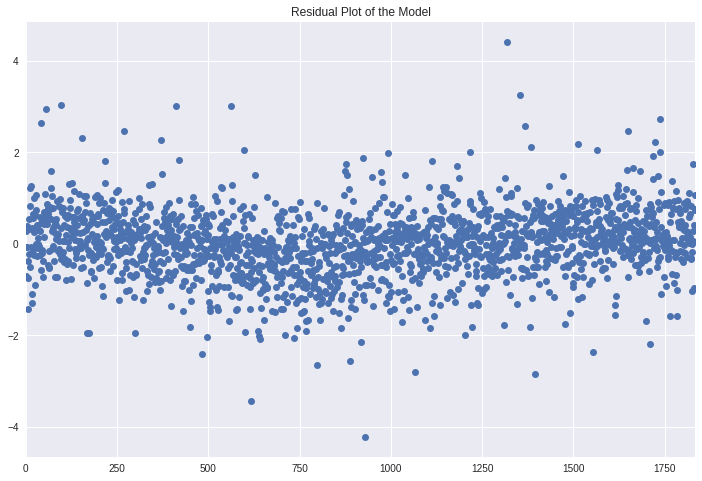

In [91]:
ax = fit.resid.plot(style='o', figsize=(12,8))
ax.set_title('Residual Plot of the Model')

In [107]:
X["intercept"] = 1
model = sm.OLS(y, X)
fit1 = model.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     log_worldwide_adjusted   R-squared:                       0.641
Model:                                OLS   Adj. R-squared:                  0.612
Method:                     Least Squares   F-statistic:                     22.24
Date:                    Fri, 06 Oct 2017   Prob (F-statistic):               0.00
Time:                            00:20:48   Log-Likelihood:                -3563.5
No. Observations:                    2370   AIC:                             7481.
Df Residuals:                        2193   BIC:                             8502.
Df Model:                             176                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
runtime                      0.0132      0.002      6.916      0.000       0.009       0.017
theaters                     0.0007   2.88e-05     25.047      0.000       0.001       0.001
year                        -0.0127      0.005     -2.571      0.010      -0.022      -0.003
log_budget_adjusted          0.4268      0.032     13.384      0.000       0.364       0.489
m_April                      1.8054      0.639      2.827      0.005       0.553       3.058
m_August                     2.0440      0.640      3.193      0.001       0.788       3.299
m_December                   2.4291      0.641      3.790      0.000       1.172       3.686
m_February                   2.0311      0.639      3.177      0.002       0.777       3.285
m_January                    2.6179      0.640      4.088      0.000       1.362       3.874
m_July                       2.1495      0.641      3.353      0.001       0.892       3.407
m_June                       2.0770      0.641      3.241      0.001       0.820       3.334
m_March                      1.9377      0.637      3.042      0.002       0.688       3.187
m_May                        2.0406      0.642      3.179      0.001       0.782       3.299
m_November                   2.1268      0.639      3.330      0.001       0.874       3.379
m_October                    1.9074      0.636      2.997      0.003       0.659       3.156
m_September                  1.8554      0.639      2.902      0.004       0.601       3.109
m_G                          5.0082      1.526      3.282      0.001       2.015       8.001
m_NC-17                      4.9736      1.600      3.108      0.002       1.836       8.112
m_PG                         5.0068      1.531      3.270      0.001       2.004       8.009
m_PG-13                      5.0286      1.527      3.293      0.001       2.034       8.023
m_R                          5.0046      1.531      3.269      0.001       2.002       8.007
g_Action                    -0.2281      0.073     -3.132      0.002      -0.371      -0.085
g_Adventure                  0.0691      0.078      0.890      0.374      -0.083       0.221
g_Animation                  0.2994      0.131      2.279      0.023       0.042       0.557
g_Biography                  0.1346      0.107      1.262      0.207      -0.075       0.344
g_Comedy                    -0.0809      0.070     -1.162      0.245      -0.218       0.056
g_Crime                     -0.2024      0.073     -2.767      0.006      -0.346      -0.059
g_Drama                      0.0222      0.066      0.336      0.737      -0.107       0.152
g_Family                     0.0310      0.149      0.207      0.836      -0.262       0.324
g_Fantasy                   -0.0844      0.082     -1.027      

In [79]:
X["intercept"] = 1
model = sm.OLS(y, X)
fit1 = model.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     log_worldwide_adjusted   R-squared:                       0.684
Model:                                OLS   Adj. R-squared:                  0.678
Method:                     Least Squares   F-statistic:                     99.81
Date:                    Fri, 06 Oct 2017   Prob (F-statistic):               0.00
Time:                            09:51:58   Log-Likelihood:                -2029.0
No. Observations:                    1835   AIC:                             4138.
Df Residuals:                        1795   BIC:                             4359.
Df Model:                              39                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
runtime                 0.0097      0.001      6.777      0.000       0.007       0.013
theaters                0.0009   2.87e-05     30.873      0.000       0.001       0.001
year                   -0.0116      0.004     -3.241      0.001      -0.019      -0.005
log_budget_adjusted     0.2539      0.029      8.724      0.000       0.197       0.311
top_director            0.4084      0.067      6.086      0.000       0.277       0.540
m_April                 1.9602      0.454      4.315      0.000       1.069       2.851
m_August                2.1044      0.457      4.605      0.000       1.208       3.001
m_December              2.3795      0.456      5.222      0.000       1.486       3.273
m_February              1.9720      0.456      4.323      0.000       1.077       2.867
m_January               2.1482      0.460      4.674      0.000       1.247       3.050
m_July                  2.2590      0.456      4.953      0.000       1.364       3.153
m_June                  2.2332      0.455      4.906      0.000       1.340       3.126
m_March                 1.9814      0.454      4.360      0.000       1.090       2.873
m_May                   2.1684      0.455      4.762      0.000       1.275       3.061
m_November              2.1773      0.454      4.800      0.000       1.288       3.067
m_October               1.9635      0.454      4.322      0.000       1.072       2.855
m_September             1.9006      0.457      4.161      0.000       1.005       2.796
m_G                     6.4073      1.353      4.735      0.000       3.753       9.061
m_PG                    6.2991      1.361      4.630      0.000       3.631       8.968
m_PG-13                 6.2663      1.357      4.617      0.000       3.605       8.928
m_R                     6.2750      1.360      4.615      0.000       3.608       8.942
g_Action               -0.1017      0.049     -2.080      0.038      -0.197      -0.006
g_Adventure             0.0612      0.053      1.156      0.248      -0.043       0.165
g_Animation             0.2070      0.090      2.311      0.021       0.031       0.383
g_Biography            -0.0477      0.092     -0.519      0.604      -0.228       0.133
g_Comedy               -0.1155      0.052     -2.204      0.028      -0.218      -0.013
g_Crime                -0.1018      0.054     -1.903      0.057      -0.207       0.003
g_Drama                -0.0221      0.046     -0.479      0.632      -0.112       0.068
g_Family               -0.0293      0.104     -0.283      0.778      -0.232       0.174
g_Fantasy              -0.0225      0.056     -0.398      0.691      -0.133       0.088
g_History               0.1164      0.118      0.986      0.324      -0.115       0.348
g_Horror                0.0512      0.066      

In [80]:
sig_columns

NameError: name 'sig_columns' is not defined

In [306]:
# Cross validate statsmodels
def evaluate_model(est, X, y, cv=10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    est.fit(X_train,y_train)
    r2 = est.score(X_test,y_test)
    cv_r2 = cross_val_score(est, X, y, cv=cv, scoring='r2')

    
    # Traintest
    cv_r2_mean = sum(cv_r2)/len(cv_r2)
    mse = mean_squared_error(y, est.predict(X))
    cv_mse =  cross_val_score(est, X, y, cv=cv, scoring='neg_mean_squared_error')
    cv_mse_mean = -sum(cv_mse)/len(cv_mse)
    
    #Repeated train/test split
    scores = []
    for i in range(cv):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        est.fit(X_train, y_train)
        scores.append(est.score(X_test, y_test))
    train = sum(scores)/len(scores)
    
    
    
    print("With {} columns".format(X.shape[1]))
    print("The MSE is {}".format(mse))
    print("The train/test split r-square is {}".format(r2))
    print("The cross-validated mean mse is {}".format(cv_mse_mean))
    print("The r-squared of the model is: {}".format(est.score(X, y)))
    print("The cross-validated mean r-squared is: {}".format(cv_r2_mean))
    print("Repeated train/test split yields a r-squared of {}".format(train))
    #print(cv_r2)


In [324]:
def evaluate_model(est, X, y, cv=10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    est.fit(X_train,y_train)
    est_pred = est.predict(X_test)
    mse_test = mean_squared_error(y_test, est.predict(X_test))
    mse_train = mean_squared_error(y_train, est.predict(X_train))
    
    r2_test = est.score(X_test, y_test)
    r2_train = est.score(X_train, y_train)
    
    
    r2_alt = r2_score(y_test, est.predict(X_test))
    print(r2_alt)
    
    '''r2 = est.score(X_test,y_test)
    cv_r2 = cross_val_score(est, X, y, cv=cv, scoring='r2')

    
    # Traintest
    cv_r2_mean = sum(cv_r2)/len(cv_r2)
    mse = mean_squared_error(y, est.predict(X))
    cv_mse =  cross_val_score(est, X, y, cv=cv, scoring='neg_mean_squared_error')
    cv_mse_mean = -sum(cv_mse)/len(cv_mse)
    
    #Repeated train/test split
    scores = []
    for i in range(cv):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        est.fit(X_train, y_train)
        scores.append(est.score(X_test, y_test))
    train = sum(scores)/len(scores)'''
    
    
    
    print("With {} columns".format(X.shape[1]))
    print("The train MSE is {}".format(mse_train))
    print("The test MSE is {}".format(mse_test))
    print("The r-squared of the training set is {}".format(r2_train))
    print("The r-squared of the testing set is {}".format(r2_test))
    
    """print("The train/test split r-square is {}".format(r2))
    print("The cross-validated mean mse is {}".format(cv_mse_mean))
    print("The r-squared of the model is: {}".format(est.score(X, y)))
    print("The cross-validated mean r-squared is: {}".format(cv_r2_mean))
    print("Repeated train/test split yields a r-squared of {}".format(train))"""
    #print(cv_r2)

In [330]:
evaluate_model(est, df_mod, df_y, cv=10)

-0.00450541196075
With 153 columns
The train MSE is 1.7356209101953801
The test MSE is 1.5977425329740753
The r-squared of the training set is 0.0
The r-squared of the testing set is -0.0045054119607483845


In [332]:
df_mod.columns

Index(['runtime', 'theaters', 'year', 'log_budget_adjusted', 'top_director',
       'm_April', 'm_August', 'm_December', 'm_February', 'm_January',
       ...
       'd_Mexico', 'd_New_Zealand', 'd_Panama', 'd_Romania', 'd_Russia',
       'd_South_Africa', 'd_Spain', 'd_UK', 'd_USA', 'd_United_Arab_Emirates'],
      dtype='object', length=153)

In [303]:
X_train, X_test, y_train, y_test = train_test_split(df_mod, df_y, test_size=0.3)

In [ ]:
est = LinearRegression()
est.fit(X_train, y_train)
split_score = est.score(X_test, y_test)


In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
est2 = LinearRegression()
# Manual r^2
est2.fit(X_train, y_train)
l = est2.predict(X_test)
ymean = sum(y_test)/len(y)
sst = sum([(x-ymean)**2 for x in y_test])
ssr = sum([(x-y)**2 for x,y in zip(l, y_test)])
1-(ssr/sst)


0.99603496801153102

In [230]:
r2_score(y_test, est2.predict(X_test))

0.65934478796396556

In [69]:
est = LinearRegression()
X = df_mod
y = df_y
evaluate_model(est, X, y,10)

NameError: name 'sig_columns' is not defined

In [135]:
est = LinearRegression()#Lasso(normalize=True)
X = df_mod
y = df_y
evaluate_model(est, X, y,10)

NameError: name 'evaluate_model' is not defined

In [71]:
#X[X.log_budget_adjusted < 10]
df_clean.loc[304]

budget                                                7000
country                                                USA
director                                     Shane Carruth
genre                              Drama, Sci-Fi, Thriller
language                                    English,French
lifetime                                            424760
mojo_url                            /movies/?id=primer.htm
opening                                              28162
rating                                                 6.9
rating_count                                        81,410
release                                2005-05-27 00:00:00
runtime                                                 77
studio                                               Think
theaters                                                 4
title                                               Primer
url                       /title/tt0390384/?ref_=adv_li_tt
worldwide                                           4247

In [72]:
df_clean.log_lifetime.describe()

count    2370.000000
mean       16.920790
std         1.876788
min         7.665753
25%        16.306673
50%        17.335720
75%        18.093064
max        20.657833
Name: log_lifetime, dtype: float64

In [73]:
est = Ridge(alpha=0.1, normalize=True)
X = df_mod
y = df_y
evaluate_model(est, X, y,10)

With 184 columns
The MSE is 1.201497200719672
The cross-validated mean mse is 1.4914982482544579
The r-squared of the model is: 0.6163549240996624
The cross-validated mean r-squared is: 0.37510183587596463
Repeated train/test split yields a r-squared of 0.5567957121705428


In [74]:
def plot_alpha(X,y, estimator, title):    #X.describe().T
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    colors = sns.hls_palette(2)

    n_steps = 5
    degree = 9
    a_exp = np.linspace(-15,1,num=n_steps)
    alpha_range = [10**a for a in a_exp] 
    #alpha_range = [0.1, 0.5, 1, 5, 10]
    
    train_error = np.empty(n_steps)
    test_error = np.empty(n_steps)
    coefs = []
    train_error_r2 = np.empty(n_steps)
    test_error_r2 = np.empty(n_steps)
    

    for i,alpha in enumerate(alpha_range):
        est = estimator(alpha=alpha, normalize=True)
        est.fit(X_train, y_train)

        train_error_r2[i] = est.score(X_test, y_test)#mean_squared_error(y_train, est.predict(X_train))
        test_error_r2[i] = est.score(X_test, y_test)#mean_squared_error(y_test, est.predict(X_test))

        train_error[i] = mean_squared_error(y_train, est.predict(X_train))
        test_error[i] = mean_squared_error(y_test, est.predict(X_test))
        coefs.append(est.coef_)


    # Plot the training and test errors against degree

    fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=True, figsize=(12,5), sharex=True)

    fig.suptitle(title)
    axes[0].plot(alpha_range, train_error, label='train', color=colors[0])
    axes[0].plot(alpha_range, test_error, label='test', color=colors[1])
    axes[0].set_ylabel('mean squared error')
    axes[0].set_xlabel('log($\lambda$)')
    axes[0].legend(loc='upper right')
    
    axes[1].plot(alpha_range, train_error_r2, label='train', color=colors[0])
    axes[1].plot(alpha_range, test_error_r2, label='test', color=colors[1])
    axes[1].set_ylabel('r-squared')
    axes[1].set_xlabel('log($\lambda$)')
    axes[1].legend(loc='upper right')

/home/jvheeswijck/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.142785024709152e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


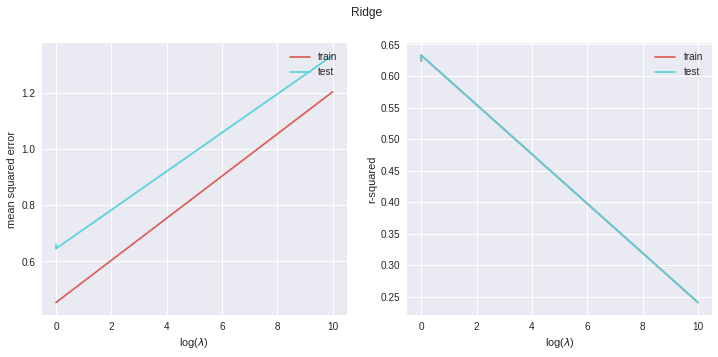

In [356]:
plot_alpha(X,y, Ridge, "Ridge")

/home/jvheeswijck/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


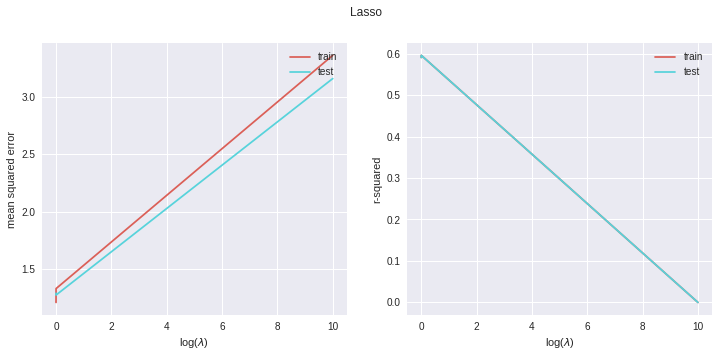

In [76]:
plot_alpha(X,y, Lasso, 'Lasso')

We can see we're overfitting, lets do a bit of feature selection. First let's try using p-value selection by looking for columns that have a low p-value, indicating that the correlation is significant

In [379]:


X = df_mod[sig_columns]
y = df_y
evaluate_model(est, X, y)

KeyError: "['d_Brazil' 'd_Georgia' 'd_Greece' 'd_Norway'] not in index"

In [81]:
sig_columns = find_sig_cols(df_mod, df_y, alpha=0.05)
sig_columns

/home/jvheeswijck/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)


['runtime',
 'theaters',
 'year',
 'log_budget_adjusted',
 'top_director',
 'm_April',
 'm_August',
 'm_December',
 'm_January',
 'm_July',
 'm_June',
 'm_May',
 'm_November',
 'm_October',
 'm_September',
 'm_G',
 'm_PG',
 'm_PG-13',
 'm_R',
 'g_Action',
 'g_Adventure',
 'g_Animation',
 'g_Biography',
 'g_Crime',
 'g_Drama',
 'g_Family',
 'g_Fantasy',
 'g_Horror',
 'g_Music',
 'g_Musical',
 'g_Romance',
 'g_Sci-Fi',
 'g_Sport']

In [106]:
evaluate_model(est, X, y)

With 184 columns
The MSE is 1.1844820718649605
The cross-validated mean mse is 88009214105741.44
The r-squared of the model is: 0.6273415537393474
The cross-validated mean r-squared is: -25108620940924.785
Repeated train/test split yields a r-squared of -2916838259893.875


In [189]:
evaluate_model(est, X, y)

With 154 columns
The MSE is 0.4957044230499696
The cross-validated mean mse is 0.6299238982683235
The r-squared of the model is: 0.6949376479465463
The cross-validated mean r-squared is: 0.4532259593659108
Repeated train/test split yields a r-squared of 0.6373144316723319


In [79]:
# Make a loop comparing normal, log, normal adjusted, log adjusted
for col in ['']

SyntaxError: invalid syntax (<ipython-input-79-960f217bc58a>, line 2)

In [194]:
X.columns.shape

(154,)

In [359]:
X = df_mod
y = df_y

In [376]:
est = Lasso(alpha=0.000001)

In [377]:
est.fit(df_mod, df_y)
mean_squared_error(df.log_worldwide_adjusted, est.predict(df_mod))

/home/jvheeswijck/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.48620584348296941

In [192]:
est = make_pipeline(PolynomialFeatures(2), LinearRegression())
evaluate_model(est, X, y)

With 154 columns
The MSE is 0.1247370948659048
The cross-validated mean mse is 11006815029262.822
The r-squared of the model is: -6465137687.49683
The cross-validated mean r-squared is: -9064987517931.426
Repeated train/test split yields a r-squared of -52995978588923.05


In [347]:
# Cross validation
score_metric = 'mean_squared_error'
scores = cross_val_score(est, X, y, cv=5, scoring=score_metric)
sum(scores)/len(scores)
#-scores

/home/jvheeswijck/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/jvheeswijck/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/jvheeswijck/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/jvheeswijck/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight

-0.62019026206367223

In [386]:
est = LinearRegression()
est.fit(X[sig_columns], y)
est.score(X[sig_columns],y)

0.69269564854774168

In [387]:
def mean(l):
    return sum(l)/len(l)

In [405]:
result = cross_val_score(est, X[sig_columns], y, scoring='r2', cv=5)
print(mean(result))

0.525939500444


In [150]:
# Single fit test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
est.fit(X_train, y_train)
est.score(X_test, y_test)

X[sig_columns].columns.shape

(33,)

In [106]:
# Multiple Average Train/Test Split
scores = []
amount = 100
mse = []
est = LinearRegression()
for i in range(amount):
    X_train, X_test, y_train, y_test = train_test_split(X[sig_columns], y, test_size=0.3)
    est.fit(X_train, y_train)
    mse.append(mean_squared_error(y_test, est.predict(X_test)))
    scores.append(est.score(X_test, y_test))
print(mean(scores))
print(mean(mse))


NameError: name 'mean' is not defined

In [156]:
X = df_mod#[sig_columns]
X_train, X_test, y_train, y_test = train_test_split(X[sig_columns], y, test_size=0.3)
est.fit(X_train, y_train)
est.score(X_test, y_test)


0.66943225372853976

In [125]:
len(sig_columns)

33

In [118]:
X.columns.shape

(42,)

In [434]:
import pprint
for r in sig_columns:
    print(r)

runtime
theaters
year
log_budget_adjusted
top_director
m_April
m_August
m_December
m_January
m_July
m_June
m_May
m_November
m_October
m_September
m_G
m_PG
m_PG-13
m_R
g_Action
g_Adventure
g_Animation
g_Biography
g_Crime
g_Drama
g_Family
g_Fantasy
g_Horror
g_Music
g_Musical
g_Romance
g_Sci-Fi
g_Sport
l_Aramaic
l_French
l_German
l_Italian
l_Japanese
l_Russian
l_Swiss_German
l_Ukrainian
d_Canada
d_China
d_Czech_Republic
d_Denmark
d_Germany
d_Kenya
d_Mexico
d_Panama
d_USA


In [422]:
result = cross_val_score(est, X[sig_columns], y, cv=5)
print(mean(result))
result = cross_val_score(est, X[sig_columns], y, cv=5, scoring='neg_mean_squared_error')
print(mean(result))

0.525939500444
-0.591599371959


In [406]:
def plot_actual_predicted(est, y, X):
    fig,ax = plt.subplots(figsize=(12,5))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    est.fit(X_train,y_train)
    ax.scatter(y_test, est.predict(X_test))
    x = np.linspace(8, 22, 50)
    ax.plot(x,x, color='red')
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Actual')
    #ax.plot(x='actual', y='predicted', data=pd.DataFrame(list(zip(y, est.predict(X))), columns=['actual', 'predicted']))

In [ ]:
# Residuals
df = pd.DataFrame()

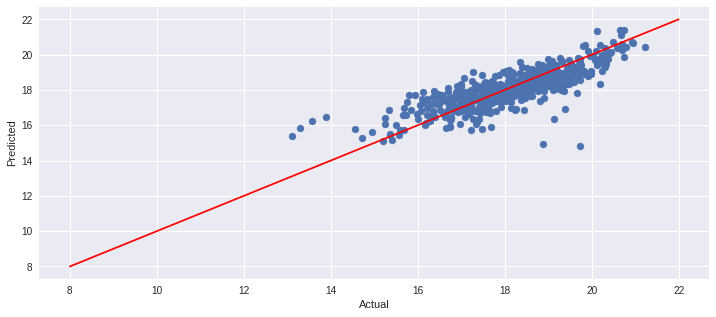

In [408]:
est = LinearRegression()
plot_actual_predicted(est, y, X)

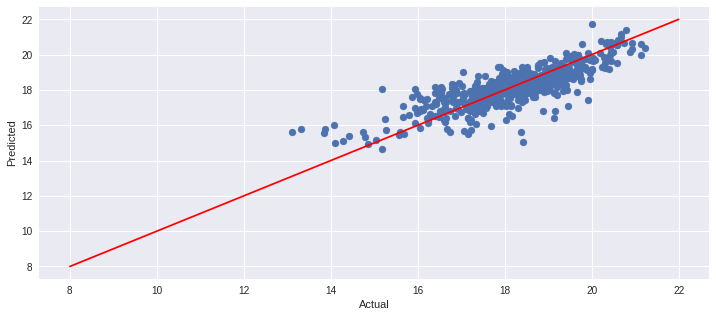

In [409]:
est = LinearRegression()#Lasso(alpha=0.001)
plot_actual_predicted(est, y[X.theaters > 100], X[X.theaters > 100])

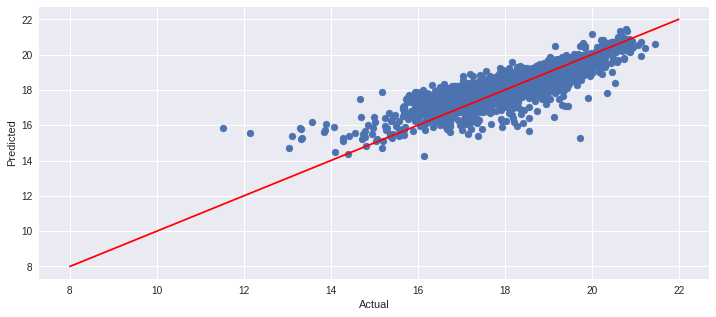

In [335]:
est = LinearRegression()#Lasso(alpha=0.001)
plot_actual_predicted(est, y[X.theaters > 100], X[X.theaters > 100])

In [ ]:
X = df_mod

In [ ]:
fig,ax = plt.subplots()
measurements = np.random.normal(loc = 20, scale = 5, size=100)
stats.probplot(measurements, dist="norm", ax=fig)
ax.show()

In [ ]:
pd.DataFrame(list(zip(y, est.predict(X)))).head()

In [ ]:
mean_squared_error(y, est.predict(X))